https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/notebook

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.shape, test.shape

((1118822, 52), (9272, 51))

In [3]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# 데이터를 동일하게 처리해주기 유용함.
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat([train, test])     # 하나의 데이터로 만들어줍니다.

## EDA

#### The Goal
- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the Target, given these features.

In [4]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [5]:
# Preview the data we're working with
df.head(3)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0


##### SalePrice: the variable we're trying to predict

In [6]:
#descriptive statistics summary
df['target'].describe()

count    1.118822e+06
mean     5.799153e+04
std      4.642602e+04
min      3.500000e+02
25%      3.050000e+04
50%      4.480000e+04
75%      6.980000e+04
max      1.450000e+06
Name: target, dtype: float64

- 중앙값이 약 57,992이고, 25%와 75% 사분위수 범위가 각각 30,500과 69,800임을 확인할 수 있습니다.
- 대부분의 데이터 포인트가 40,000과 80,000 사이에 집중되어 있습니다.
- positive skewness


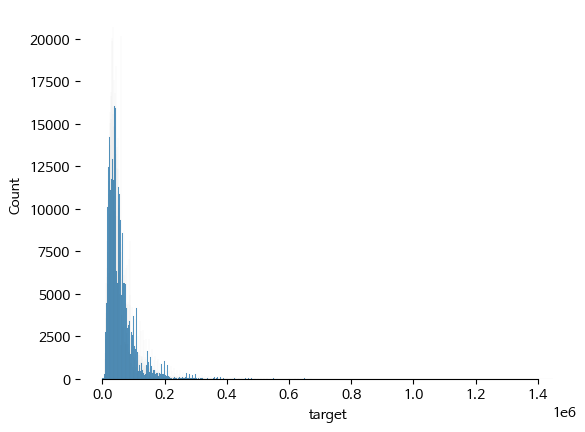

In [7]:
# sns.set_style('white')
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8,7))
sns.histplot(df['target'])
sns.despine(trim=True, left=True)
plt.show()

- skewness가 -1보다 작거나 1보다 클 경우 데이터는 상당히 치우쳐있다.
- 첨도(kurtosis)값이 3에 가까우면 산포도가 정규분포에 가깝다.

In [8]:
# Skew and kurt
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 3.517641
Kurtosis: 25.465357


##### Relationship with numerical variables

In [6]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
df = df.rename(columns={'전용면적(㎡)':'전용면적'})


- target 과 그나마 가장 Linear 한 관계는 **전용면적**이다.
- 최근의 건축년도와 계약년월에서 가장 높은 target 이 등장한다.

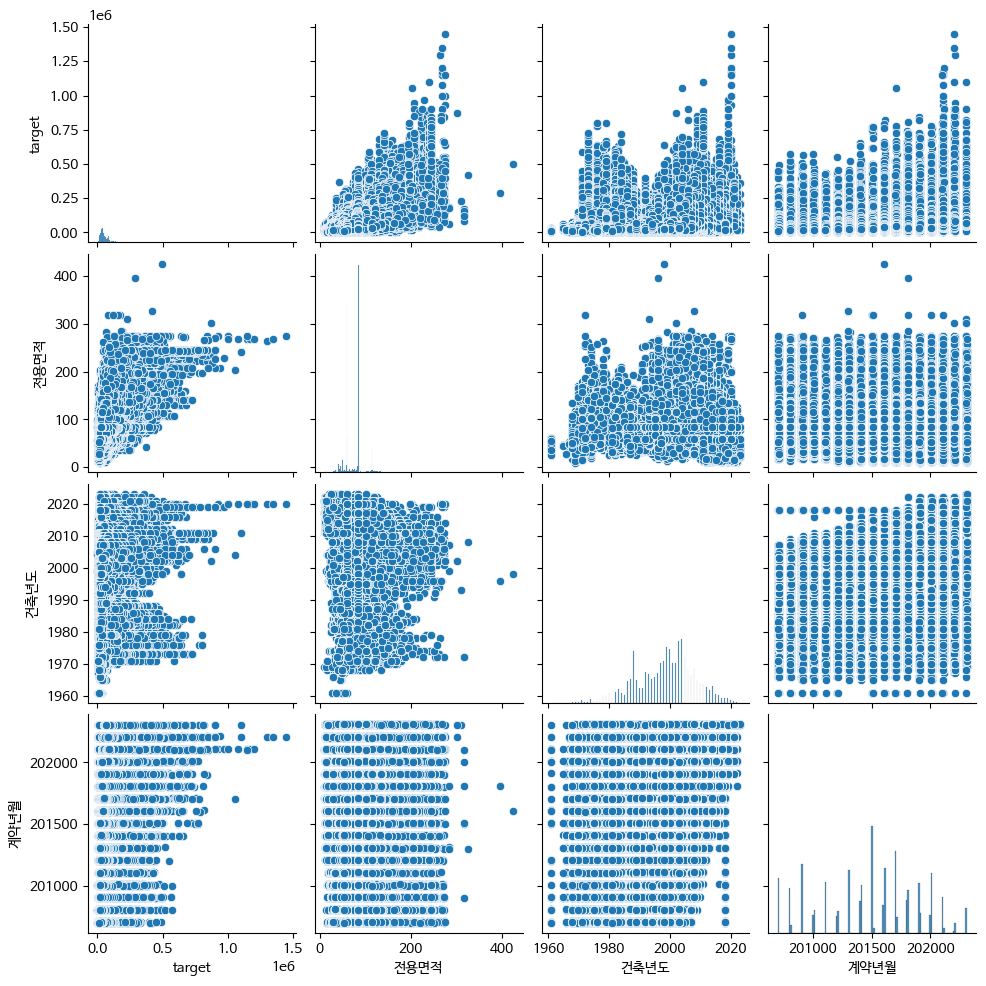

In [10]:
# scatterplot
cols = ['target', '전용면적', '건축년도', '계약년월']
sns.pairplot(df[cols], size=2.5)
plt.show()

In [7]:
df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4])
df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:])

<Axes: xlabel='계약년', ylabel='target'>

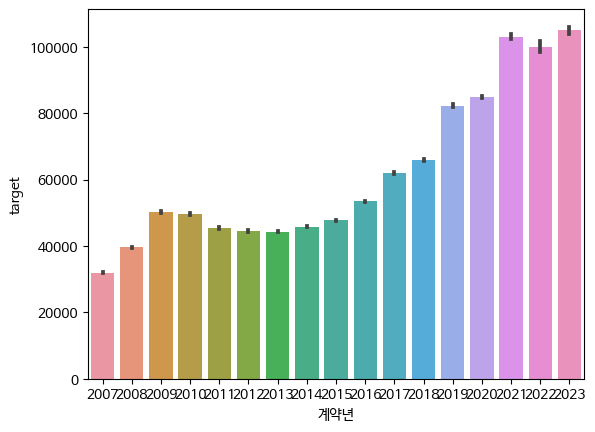

In [12]:
data = df[['계약년', 'target']].sort_values(by='계약년').reset_index()

sns.barplot(x='계약년', y='target', data=data)

<Axes: xlabel='계약년', ylabel='target'>

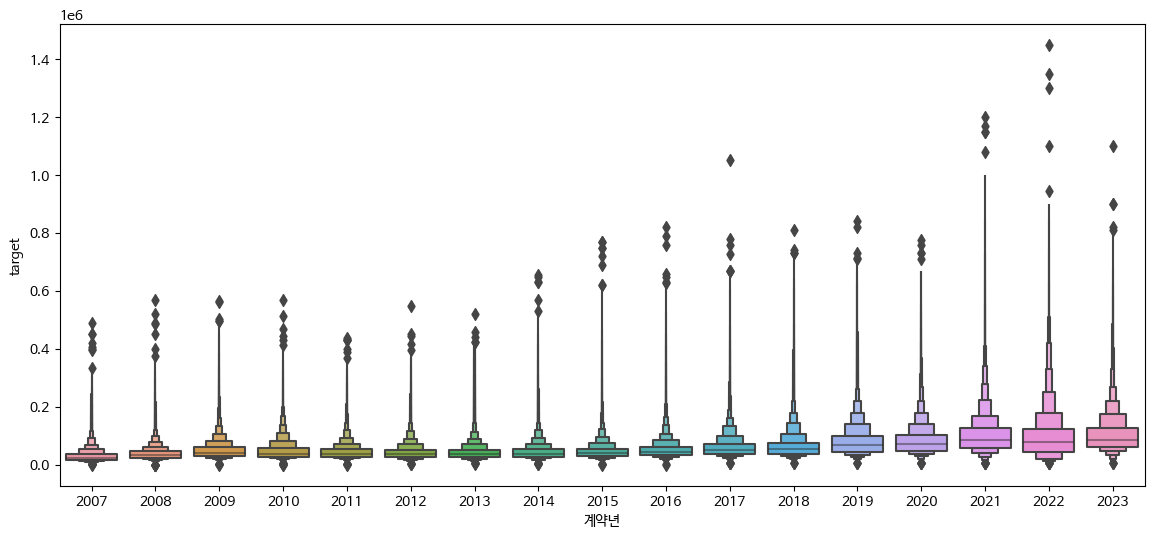

In [13]:
plt.figure(figsize=(14,6))
sns.boxenplot(x='계약년', y='target', data=data)

##### Relationship with numerical variables

In [8]:
df['구'] = df['시군구'].apply(lambda x:x.split()[1])
df['동'] = df['시군구'].apply(lambda x:x.split()[2])

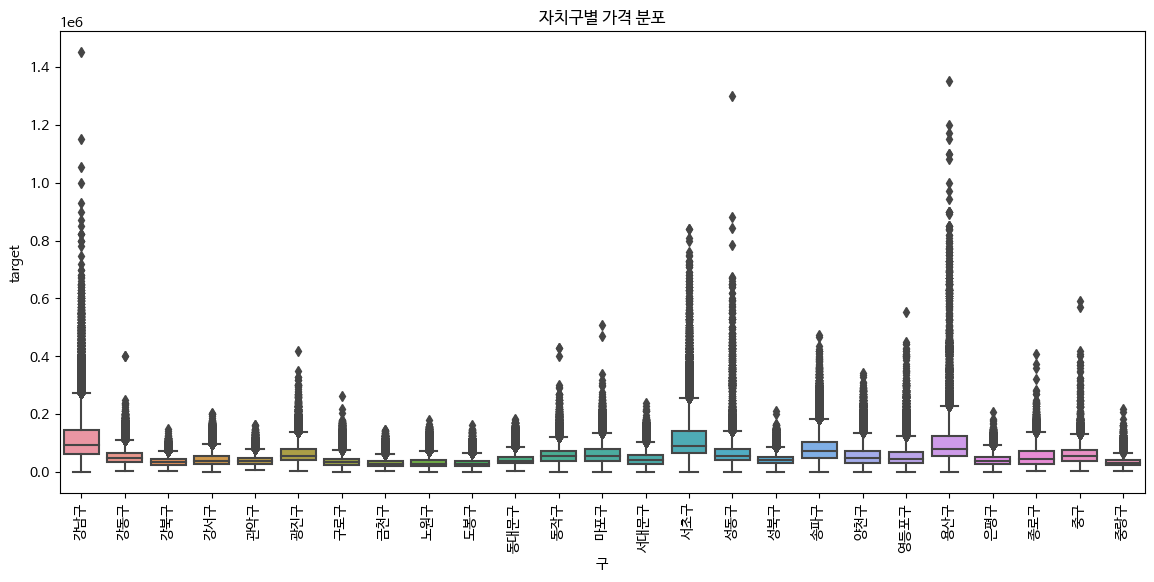

In [15]:
var = '구'
data = pd.concat([df['target'], df[var]], axis=1)

plt.figure(figsize=(14,6))
sns.boxplot(x=var, y='target', data=data)
plt.xticks(rotation=90)
plt.title('자치구별 가격 분포')
plt.show()

In [16]:
df_group = df[['target', '구']].groupby('구').describe()['target'].sort_values(by='std', ascending=False).reset_index()
df_group.head()
# df_group.sort_values(by='std_dev', ascending=False).reset_index()

,구,count,mean,std,min,25%,50%,75%,max
0,용산구,20551.0,105876.961900,90148.440633,2000.0,55200.0,81000.0,125000.0,1350000.0
1,강남구,69083.0,114847.461503,78572.045476,1000.0,64000.0,93000.0,147500.0,1450000.0
2,서초구,53126.0,113608.653390,74485.257724,500.0,65000.0,92000.0,141000.0,840000.0
3,송파구,73785.0,83868.032920,47626.592378,500.0,50500.0,72000.0,104000.0,473000.0
4,성동구,39358.0,68924.389400,45378.104410,700.0,42000.0,57000.0,81800.0,1300000.0


- 단위는 만원으로 보임 - 가장 비싼 아파트 145억
- 표준편차도 상당히 높아 가격 분포에 차이가 크다 (이상치를 제거하면 안됨)
- 최대값과 최소값의 차이도 매우 크다.
    - 한 아파트에서의 차이 (계약 날짜)
    - 같은 계약 년월의 차이 -> 많은 변수

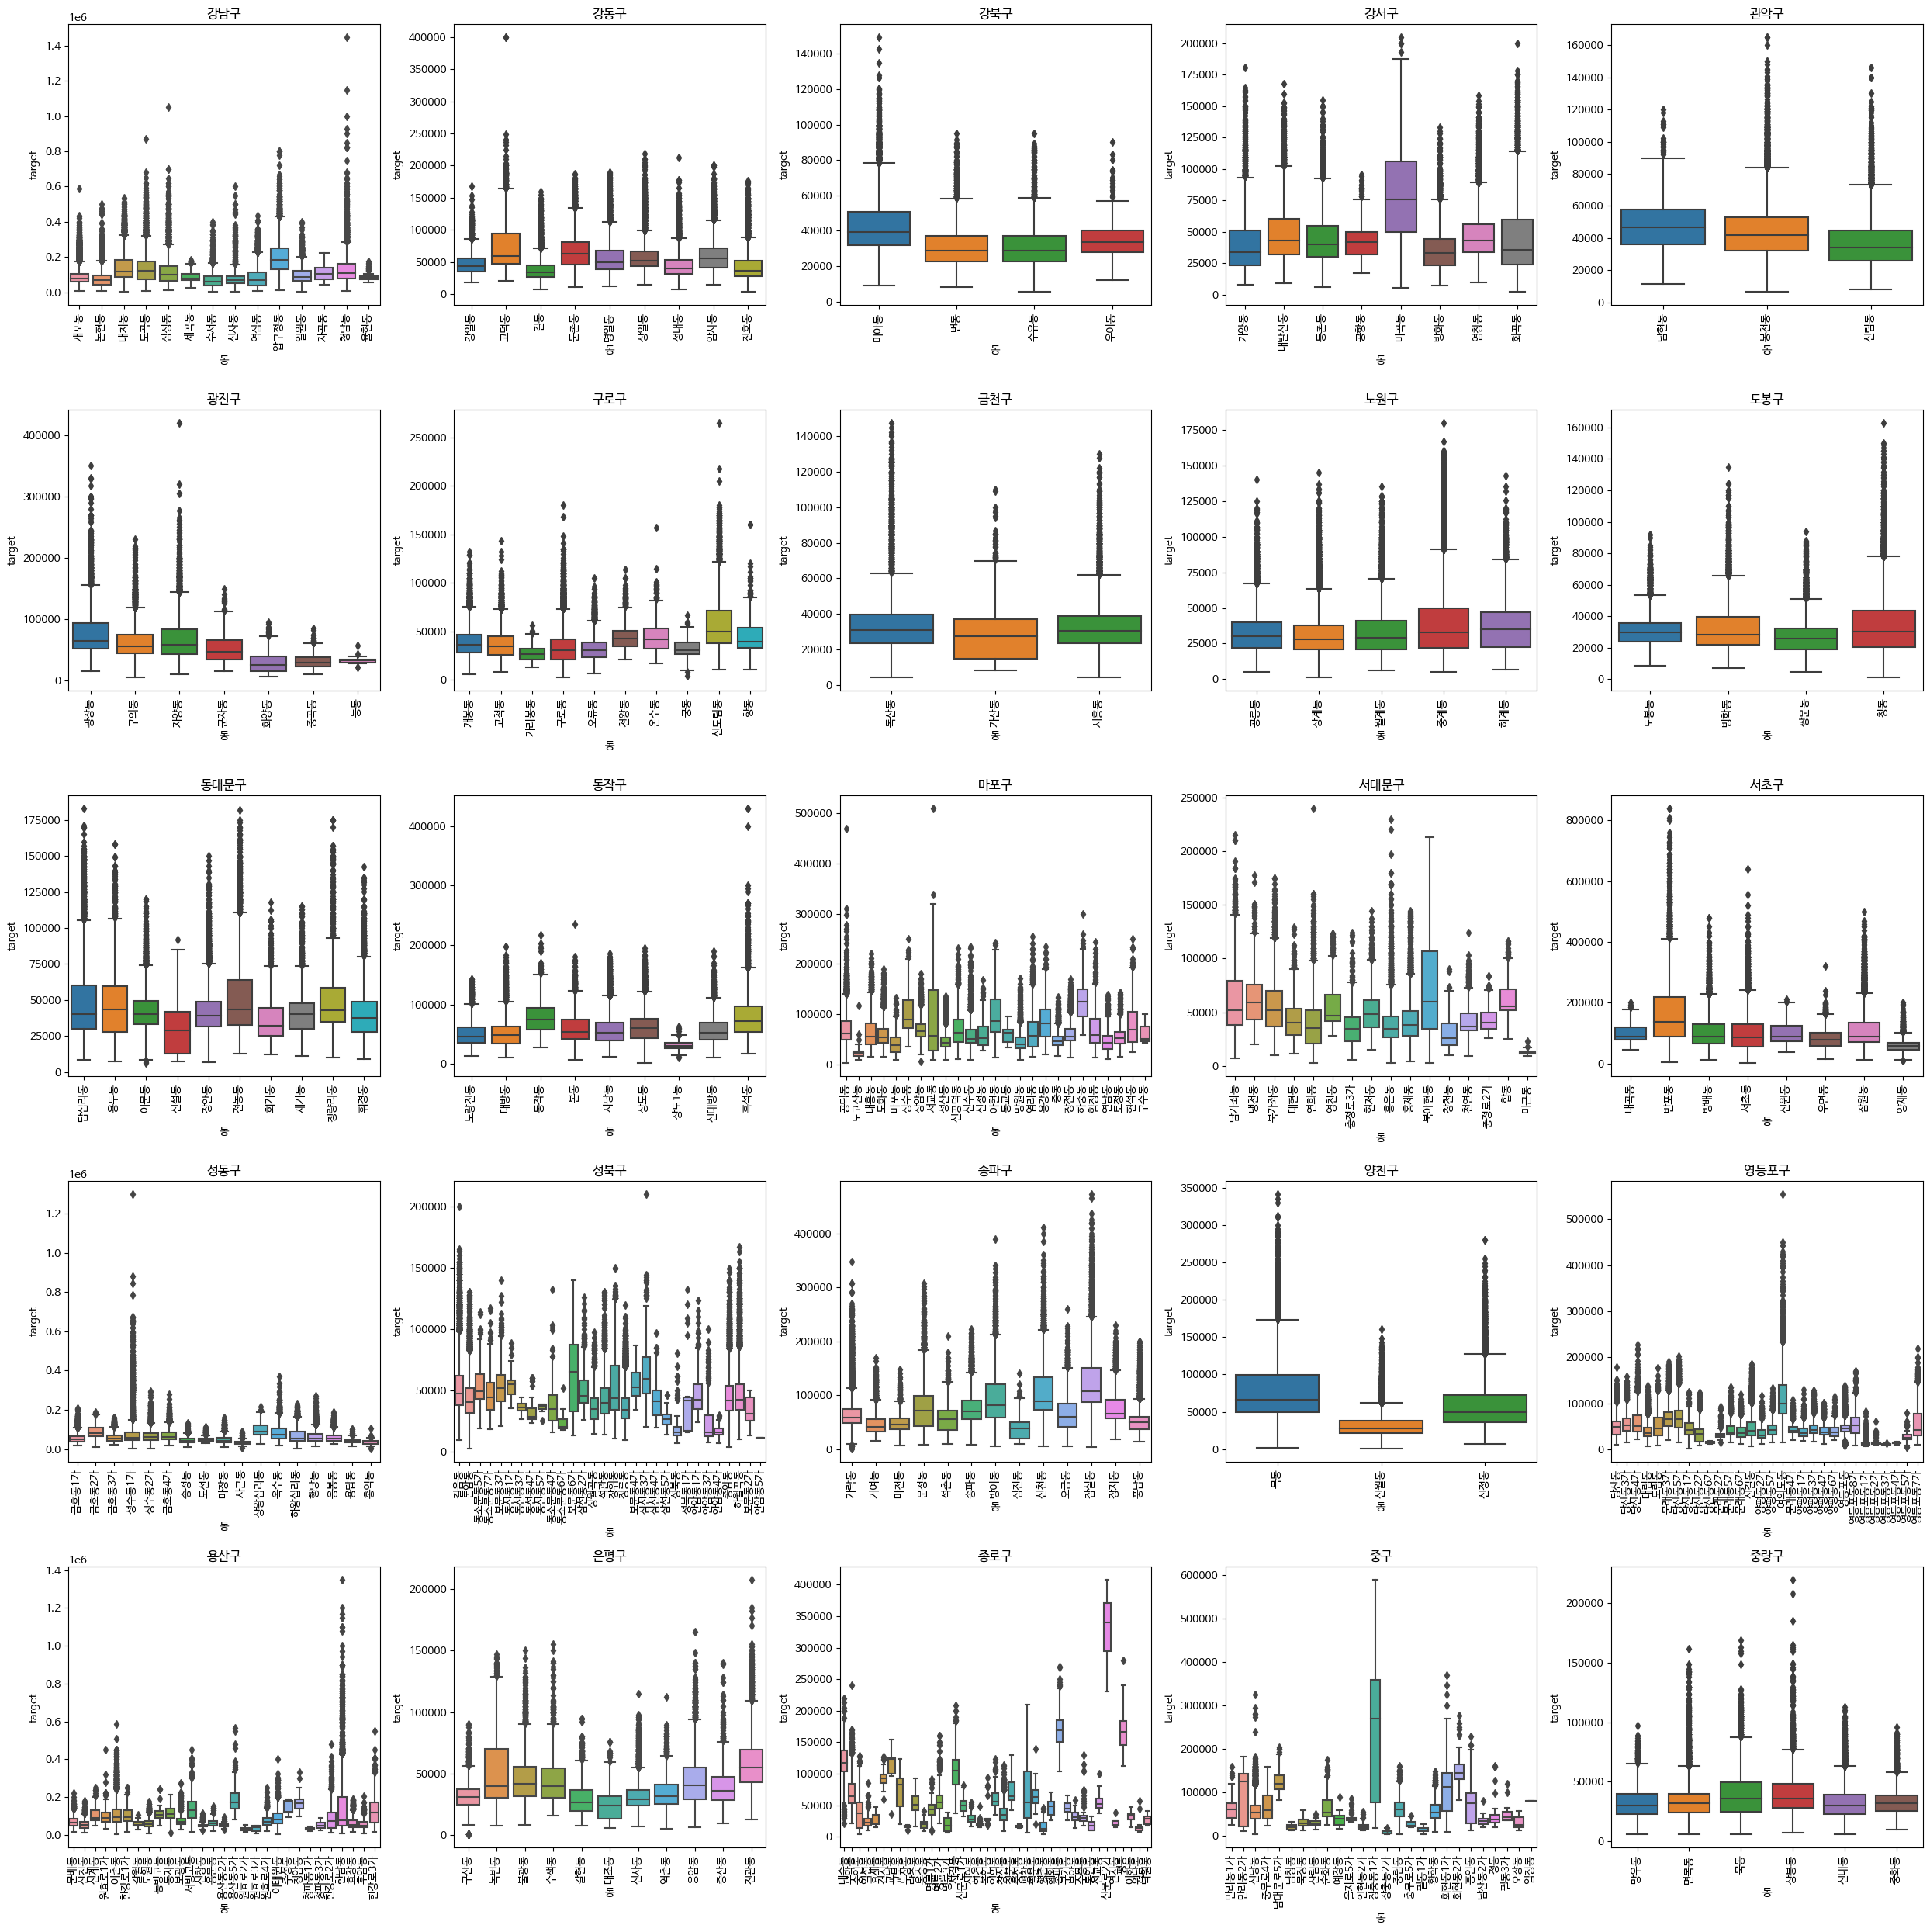

In [17]:
# 구별 데이터 그룹화
grouped_df = df[['target', '구', '동']].groupby("구")

# 5 by 5 subplots 생성
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

# 각 subplot에 boxplot 그림
for i, (구, df) in enumerate(grouped_df):
    ax = axes[i // 5, i % 5]
    sns.boxplot(data=df, x="동", y="target", ax=ax)
    ax.set_title(구)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# 전체 그림 표시
plt.tight_layout()
plt.show()

- 특정 '구'에 포함된 `동` 데이터에 주목할 필요가 있음
- 이를 세세하게 분석하여 **파생변수** 로 생성해주는 것도 유의미할 수 있음
    - 대체적으로 싼/비싼 동네
        - 20억 언저리 - '강북구', '강서구', '관악구', '구로구', '금천구', '노원구', '도봉구', '동대문구', '서대문구', '성북구', '은평구', '중랑구'
        - 40억 이상이 많이 존재하는 곳 - '강남구', '서초구' '용산구'
        - ***이때, 유의사항으로, 영등포구 같은 경우, 여의도동을 제외한 동은 20억 언저리임*** -> **세분화할 필요가 있음**

- '구'의 특성에서 벗어난게 많아서 '동' 의 구분을 해주었으면 하는 동네
    - '용산구', '중구', '종로구', '영등포구', '성북구', '성동구', '광진구', '강남구'
    

In [19]:
df[['target', '동']].groupby(by='동')['target'].describe().sort_values(by='std', ascending=False).head(50)

,count,mean,std,min,25%,50%,75%,max
동,,,,,,,,
한남동,2689.0,163018.425437,186577.761692,7000.0,47500.0,78500.0,200000.00,1350000.0
장충동1가,33.0,255131.818182,152718.687553,18530.0,76500.0,270000.0,360000.00,590000.0
반포동,11313.0,165584.328383,100821.951289,5000.0,89400.0,137000.0,218000.00,840000.0
성수동1가,3705.0,92194.085290,100050.693828,1262.0,44500.0,58000.0,87000.00,1300000.0
압구정동,4757.0,203222.949968,97856.744540,11000.0,130000.0,183500.0,249500.00,800000.0
청담동,4268.0,132711.905342,96135.204997,5000.0,76000.0,106600.0,160000.00,1450000.0
삼성동,5844.0,118605.342231,84771.397998,9750.0,65000.0,98000.0,147000.00,1053000.0
도곡동,9532.0,134878.969157,83350.468649,8500.0,75000.0,119300.0,174000.00,870000.0
한강로3가,742.0,126570.308625,80033.062136,15000.0,64125.0,119000.0,170000.00,550000.0
